# 《用纯Python手搓经典计算机视觉算法》开源教材 · 小作业2 —— Softmax 线性分类器

> **版本号：v0.1**
>
> 前言：本篇章是山东大学（威海）2023级数科班nailorch小组大作业第二阶段展示内容，小组成员：魏子钦，刘艺航，刘宇，李暄，钦浩然。本章内容围绕深度学习线性分类器中的softmax分类器展开，本文代码所用编程语言为纯python，不含任何框架，简单易上手，希望能给刚入门的小白一点启发。

# 0.导言
在生活中，我们通常会遇到许多分类问题。我们对分类问题感兴趣：不是问“多少”，而是问“哪一个”：

* 某个电子邮件是否属于垃圾邮件文件夹？

* 某个用户可能注册或不注册订阅服务？

* 某个图像描绘的是驴、狗、猫、还是鸡？

* 某人接下来最有可能看哪部电影？

Softmax从字面上来说，可以分成soft和max两个部分。max故名思议就是最大值的意思。Softmax的核心在于soft，而soft有软的含义，与之相对的是hard（硬）。很多场景中需要我们找出数组所有元素中值最大的元素，实质上都是求的hardmax。通常，机器学习实践者用分类这个词来描述两个有微妙差别的问题： 1. 我们只对样本的“硬性”类别感兴趣，即属于哪个类别； 2. 我们希望得到“软性”类别，即得到属于每个类别的**概率**。 这两者的界限往往很模糊。其中的一个原因是：即使我们只关心硬类别，我们仍然使用软类别的模型。


# 1. Softmax激活函数（Softmax Activation Function）

单纯谈softmax，其实它就是一个函数，这个函数要有它的用的地方才能发挥它的作用，而我们通常会在神经网络的最后一层见到它。可能你有训练过神经网络来解决多类别分类（multiclass classification）问题，如果有，你一定知道，神经网络的原始输出往往很难解释。而Softmax 激活函数通过让神经网络的输出更易于理解为你解决了这一难题。Softmax 激活函数把神经网络的原始输出转换为一个概率向量，本质上是输入各个类别上的概率分布。考虑一个具有 N 个类别的多分类问题。Softmax 激活会返回一个长度为 N 的输出向量，其中索引为 i 的条目对应于某个输入属于第 i 类的概率。这里看不懂没关系，我们接着往下一点点拆解。


## 1.1多分类问题

回想一下，在二分类中，只有两种可能的类别，而在多分类中，则存在两种以上的可能类别。让我们考虑以下示例：给定一个包含熊猫、海豹和鸭子图像的数据集。你想训练一个分类器来预测一张之前未见过的图像是海豹、熊猫还是鸭子。请注意，下面的输入类别标签是如何进行独热编码的，并且这些类别是互斥的。在这种情况下，互斥性意味着给定图像一次只能是{海豹、熊猫、鸭子}中的一种。

> 独热编码（One-Hot Encoding）：一种将分类变量转换为二进制向量的技术。它的主要目的是将离散的、无序的特征值转换为机器学习算法可以处理的格式。独热编码是一个向量，它的分量和类别一样多。 类别对应的分量设置为1，其他所有分量设置为0。例如，对于我们考虑的这个例子 ，独热编码后的结果为：海豹 => [1, 0, 0]；熊猫 => [0, 1, 0]；鸭子 => [0, 0, 1]

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/2d1e97e5ba2540339d16ecdfc919f8750027e0d6a5f04788b8c77f2bd98eba46" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">多类分类示例</span>
</p>

## 1.2  Sigmoid与Argmax 
### 1.2.1 Sigmoid函数的局限性
提到二分类首先想到的可能就是逻辑回归算法。逻辑回归算法是在各个领域中应用比较广泛的机器学习算法。逻辑回归算法本身并不难，最关键的步骤就是将线性模型输出的实数域映射到[0, 1]表示概率分布的有效实数空间，其中Sigmoid函数刚好具有这样的功能从数学上讲，Sigmoid激活函数由以下等式给出，它将所有输入压缩到范围 [0, 1] 内：

$$ 
\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^z}{1 + e^z} 
$$
$$ 
\sigma(z) \to 0 \text{ as } z \to -\infty 
$$
$$ 
\sigma(z) \to 1 \text{ as } z \to \infty 
$$


Sigmoid函数将任意实数作为输入，并将其映射到 0 到 1 之间的数字。这正是它非常适合二元分类的原因。

▶️ 您可以运行以下代码来绘制一系列数字上的Sigmoid函数值。



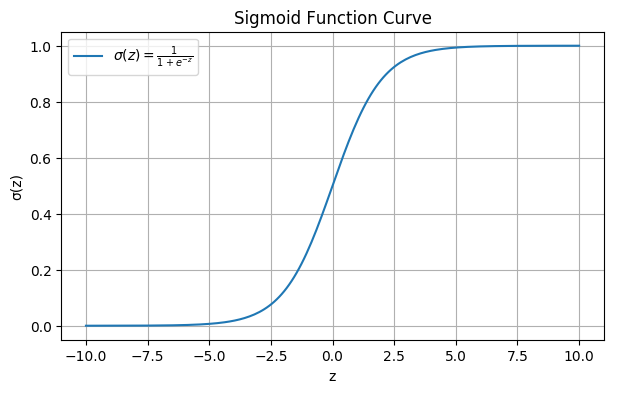

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Sigmoid 函数
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# 生成一系列输入（从 -10 到 10，共 200 个点）
z = np.linspace(-10, 10, 200)
s = sigmoid(z)

# 绘图
plt.figure(figsize=(7, 4))
plt.plot(z, s, label=r'$\sigma(z) = \frac{1}{1 + e^{-z}}$')
plt.title("Sigmoid Function Curve")
plt.xlabel("z")
plt.ylabel("σ(z)")
plt.grid(True)
plt.legend()
plt.show()


让我们回到之前的例子，判断输入图像是否为熊猫。在这个例子中，令 z 为神经网络的原始输出。如果 σ(z) 表示给定图像属于第 1 类（熊猫）的概率，那么 1 - σ(z) 表示给定图像不属于第 1 类且不是熊猫的概率。你可以将 σ(z) 视为一个概率分数。然而，当你有两个以上的类别时，这种方法就行不通了.

在多分类任务中，若对每个类别都使用 Sigmoidde得出：
$$
\sigma(z_1), \sigma(z_2), \sigma(z_3)
$$
它们是彼此独立的，并 **不满足概率和为 1**，比如，结果可能出现：
$$
\sigma(z_1)=0.9,\;\sigma(z_2)=0.8,\;\sigma(z_3)=0.7
$$
显然无法用概率解释，也无法仅通过阈值区分唯一类别。因此，Sigmoid **不适合多分类**。

Softmax 则通过：
$$
p_k = \frac{e^{z_k}}{\sum_{j=1}^{N} e^{z_j}}
$$
强制所有类别的概率和为 1，使类别间产生竞争关系，更适合作为多分类任务的输出激活函数。事实上，你可以把softmax函数看作是sigmoid激活函数的向量泛化——当N = 2时，softmax和sigmoid激活函数是等价的，我们可以用一个二维输出向量 $\mathbf{z} = [z_0, z_1]$ 来说明这一点。Softmax 的定义为：

$$
\mathrm{softmax}(\mathbf{z})_k = \frac{e^{z_k}}{e^{z_0} + e^{z_1}}
$$

对于第 0 类：

$$
\mathrm{softmax}(\mathbf{z})_0
= \frac{e^{z_0}}{e^{z_0} + e^{z_1}}
$$

令 $(z = z_0 - z_1)$，可得：

$$
\mathrm{softmax}(\mathbf{z})_0
= \frac{e^{z}}{1 + e^{z}}
= \frac{1}{1 + e^{-z}}
= \sigma(z)
$$

同理，对第 1 类：

$$
\mathrm{softmax}(\mathbf{z})_1
= \frac{e^{z_1}}{e^{z_0} + e^{z_1}}
= \frac{1}{1 + e^{z}}
= 1 - \sigma(z)
$$

观察在这种情况下 softmax 激活分数与 sigmoid 激活分数相同：σ(z) 和 1 - σ(z)



### 1.2.2 Argmax 函数的局限性
argmax 函数返回输入数组中最大值的索引。假设神经网络的原始输出向量为z = [0.25, 1.23, -0.8]。在这种情况下，最大值为 1.23，位于索引 1 处。在我们的图像分类示例中，索引 1 对应于第二类，并且该图像被预测为熊猫。在向量表示法中，最大值出现的索引处（向量z的索引为 1 ）为 1。所有其他索引处均为 0。

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/f2325964ef954f9097163bf392df7e8213b624ecb7f340a69e4e829f6c1df1b8" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">Argmax 输出</span>
</p>

使用 argmax 函数的一个限制是，它相对于神经网络原始输出的梯度始终为零。众所周知，梯度的反向传播促进了神经网络的学习过程。由于在反向传播过程中，你必须将 argmax 输出的所有梯度代入 0 值，所以你无法在训练中使用 argmax 函数。除非进行梯度反向传播，否则神经网络的参数无法调整，实际上也就没有学习。从概率的角度来看，请注意 argmax 函数如何将所有质量放在索引 1（预测类别）上，而其他位置则为 0。因此，从 argmax 输出中推断预测类别标签非常简单。然而，我们想知道图像是熊猫、海豹或鸭子的可能性有多大，这种“软性”需求是argmax所不能达到的。


## 1.3 Softmax是什么

softmax激活函数接收一个神经网络原始输出向量作为输入，并返回一个概率分数向量。softmax函数的方程定义如下：

$$
\mathrm{softmax}(\mathbf{z})_i
= \frac{e^{z_i}}{\displaystyle \sum_{j=1}^{N} e^{z_j}}
$$

其中，
$
\mathbf{z} 
$
表示输入向量；e是自然常数，数值约为2.718

回想一下，在我们的例子中，N = 3，因为我们有 3 个类：{海豹、熊猫、鸭子}，有效索引为 0、1 和 2。假设给定神经网络原始输出的向量z = [0.25, 1.23, -0.8]。让我们将 softmax 公式应用于向量z，使用以下步骤：①计算每个条目的指数②将步骤 1 的结果除以所有条目的指数之和。
<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/5e41f333a53a4551a2befebc5dd980deadd179ce6c764a6fb236abd2267fe6b9" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">计算3个类别的softmax分数</span>
</p>

现在我们已经计算出了 softmax 分数，让我们将它们收集到一个向量中以进行简洁的表示，如下所示：

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/3c891c8ab6cc497f8293e7c74fa9faaff41d9b0fe8c74c7b96352a2090243ca1" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">Softmax输出</span>
</p>

从上面的softmax输出，我们可以得出以下观察结果：

* 在原始输出向量z中，最大值为 1.23，应用 softmax 激活函数后，其值映射到 0.664：softmax 输出向量中的最大项。同样，0.25 和 -0.8 分别映射到 0.249 和 0.087：softmax 输出向量中第二大和第三大项。因此，应用 softmax 函数可以保留分数的相对顺序。
* softmax 输出向量都在 0 和 1 之间。
* 在多类分类问题中，类别是互斥的，请注意 softmax 输出的条目总和为1：0.664 + 0.249 + 0.087 = 1。

这就是为什么我们可以将softmax输出视为输入类别的概率分布，这使得它易于解释。

在向量 softmax( z ) = [0.664, 0.294, 0.087] 中，索引 1 处的 0.664 是最大值。这意味着给定图像属于类别 1 的概率为 66.4%，而根据我们的独热编码，该类别属于熊猫类。输入图像有 29.4% 的可能性是海豹，有 8.7% 的可能性是鸭子。因此，应用softmax可以立即提供可解释性，因为我们可以知道测试图像属于这三个类别的可能性。在这个特定的例子中，它很可能是熊猫，而鸭子的可能性最小。现在，在 softmax 输出上调用 argmax 函数来获取预测的类标签就变得有意义了。由于预测的类标签是概率得分最高的标签，因此您可以使用它argmax(softmax(z))来获取预测的类标签。在我们的示例中，最高概率得分 0.664 出现在索引 1 处，对应于类 1（熊猫）。


# 2.损失函数
## 2.1 全连接层网络架构
> 仿射函数：仿射函数是由一阶多项式构成的函数，通常表示为 f(x) = Ax + b，其中 A 是一个矩阵，x 是一个向量，b 是一个向量。仿射函数反映了一种从k维到m维的空间映射关系，主要用于维度改变或形状、方向的改变，这个过程称为仿射变换。仿射函数是线性函数的一种推广，具有广泛的应用。

为了估计所有可能类别的条件概率，我们需要一个有多个输出的模型，每个类别对应一个输出。为了解决线性模型的分类问题，我们需要和输出一样多的**仿射函数（affine function）**。 每个输出对应于它自己的仿射函数。在我们的例子中，假设每次输入是一个2×2的灰度图像(假如输入一个熊猫的图像，我们把它分成四块，竖一刀横一刀)，我们可以用一个标量表示每个像素值，每个图像对应四个特征$x_1$,$x_2$,$x_3$,$x_4$。由于我们有 4 个特征和 3 个可能的输出类别，我们将需要 12 个标量来表示权重（带下标的w），3 个标量来表示偏置（带下标的b）。下面我们为每个输入计算三个未规范化的预测（logit）：$o_1$、$o_2$和$o_3$。
$$
o_1 = x_1 w_{11} + x_2 w_{12} + x_3 w_{13} + x_4 w_{14} + b_1,
$$
$$
o_2 = x_1 w_{21} + x_2 w_{22} + x_3 w_{23} + x_4 w_{24} + b_2, 
$$
$$
o_3 = x_1 w_{31} + x_2 w_{32} + x_3 w_{33} + x_4 w_{34} + b_3.
$$

我们可以用下图来描述这个计算过程与线性回归一样，softmax回归也是一个单层神经网络。由于计算每个输出$o_1$、$o_2$和$o_3$取决于所有输入$x_1$,$x_2$,$x_3$,$x_4$，所以 softmax回归的输出层也是**全连接层**。

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/5145f00cf885466aa6d4375423a578746d1fd086b8c84ce29d80cef82350052f" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">softmax回归是一种单层神经网络</span>
</p>

>全连接层（Fully Connected Layer），简称 FC 层，是人工神经网络中的基础层之一。最早应用于多层感知机（MLP），其功能是将输入数据的所有特征映射到输出层，进行分类或回归等任务。全连接层是神经网络中的最后一层，也被称为“密集连接层”。在全连接层中，输入的每个神经元都与输出的每个神经元相连接。全连接层通过对输入的线性变换和激活函数的非线性变换，将高维特征压缩或映射到目标维度。

## 2.1附 全连接层的参数开销
正如我们将在后续神经网络中会学到的一样，在深度学习中，全连接层无处不在。然而，顾名思义，全连接层是 “完全” 连接的，可能有很多可学习的参数。具体来说，对于任何具有d个输入和q个输出的全连接层，参数开销为$\mathcal{O}(dq)$，这个数字在实践中可能高得令人望而却步。幸运的是，将d个输入转换为q个输出的成本可以减少到$\mathcal{O}(\frac{dq}{n})$，其中超参数n可以由我们灵活指定，以在实际应用中平衡参数节约和模型有效性.
## 2.2 softmax求导
现在可以构建比较复杂的神经网络模型，最重要的原因之一得益于**反向传播算法**。反向传播算法从输出端也就是损失函数开始向输入端基于链式法则计算梯度，然后通过计算得到的梯度，应用梯度下降算法迭代更新待优化参数。由于反向传播计算梯度基于**链式法则**，因此下面为了更加清晰，首先推导一下Softmax函数的导数。作为最后一层的激活函数，求导本身并不复杂，但是需要注意需要分成**两种情况**来考虑。

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/e12312af3a3b435989c48cd95453f1ccec2ec044da1a49d4970f7c8d5f79db73" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">一个具体的例子</span>
</p>

我们以上图中具体例子来对softmax求导，绘制拥有三个输出节点的Softmax函数的计算图：

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/c175af0b5b8846879e3c1943985b20094591266aef524a5f98e5d75fb521c2f3" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">拥有三个输出节点的Softmax函数的计算图</span>
</p>

回顾 Softmax 函数的表达式：

$$
Softmax(z_i) = \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}
$$

其中 $i$ 表示输出节点的编号。

影响 $y_1$ 的有与之相连的 $e^{z_1}, e^{z_2}, e^{z_3}$，因此需要分别求出 $\frac{\partial y_1}{\partial z_1}$、$\frac{\partial y_1}{\partial z_2}$、$\frac{\partial y_1}{\partial z_3}$。此时输出值 $y_1$ 为

$$
y_1 = \frac{e^{z_1}}{e^{z_1} + e^{z_2} + e^{z_3}}
$$

很明显，$\frac{\partial y_1}{\partial z_1}$ 与 $\frac{\partial y_1}{\partial z_2}$、$\frac{\partial y_1}{\partial z_3}$ 结果不同，而 $\frac{\partial y_1}{\partial z_2}$、$\frac{\partial y_1}{\partial z_3}$ 只需换相应索引即可。因此在对 Softmax 函数求导时，需要分两种情况考虑。即对第 $i$ 个输出节点，分别对 $j=i$ 的 $z_j$，求导以及其它 $j\ne i$ 的 $z_j$ 求导。

对 $j=i$ 时，类似前面介绍的 $\frac{\partial y_1}{\partial z_1}$，Softmax 函数的偏导数可以展开为：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{(e^{z_i})' \sum_{c=1}^{C} e^{z_c} - e^{z_i} (\sum_{c=1}^{C} e^{z_c})'}{(\sum_{c=1}^{C} e^{z_c})^2}
$$

上面使用了函数相除的导数运算，由于是对 $z_j$ 求导，若此时 $j=i$，因此 $e^{z_i}$ 的导数还是 $e^{z_i}$ 本身，对 $\sum_{c=1}^{C} e^{z_c}$ 求导结果只保留 $e^{z_j}$。因此上面求导的结果为：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{e^{z_i} \sum_{c=1}^{C} e^{z_c} - e^{z_i} e^{z_j}}{(\sum_{c=1}^{C} e^{z_c})^2}
$$

提取公共项 $e^{z_i}$：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{e^{z_i}(\sum_{c=1}^{C} e^{z_c} - e^{z_j})}{(\sum_{c=1}^{C} e^{z_c})^2}
$$

拆分成两部分：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \times \frac{\sum_{c=1}^{C} e^{z_c} - e^{z_j}}{\sum_{c=1}^{C} e^{z_c}}
$$

为了方便，将 Softmax 函数表达式 $Softmax(z_i) = \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}$ 表示为 $p_i$，结果为

$$
p_i(1 - p_j)
$$

由于此时 $j=i$，则 $p_i=p_j$，因此最终结果为 $p_i - (p_i)^2$。

对 $j\ne i$ 时，类似前面介绍的 $\frac{\partial y_1}{\partial z_2}$ 或 $\frac{\partial y_1}{\partial z_3}$，Softmax 函数的偏导数 $\frac{\partial y_i}{\partial z_j}$ 可以展开为：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{(e^{z_i})' \sum_{c=1}^{C} e^{z_c} - e^{z_i} (\sum_{c=1}^{C} e^{z_c})'}{(\sum_{c=1}^{C} e^{z_c})^2}
$$

上面使用了函数相除的导数运算，由于是对 $z_j$ 求导，若此时 $j\ne i$，因此 $e^{z_i}$ 相当于常数，常数的导数为 0，对 $\sum_{c=1}^{C} e^{z_c}$ 求导同样只保留 $e^{z_j}$。因此上面求导的结果为：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= \frac{0 - e^{z_i} e^{z_j}}{(\sum_{c=1}^{C} e^{z_c})^2}
$$

分解两项相乘：

$$
\frac{\partial}{\partial z_j}\left( \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \right)
= -\frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}} \times \frac{e^{z_j}}{\sum_{c=1}^{C} e^{z_c}}
$$

为了方便，将 Softmax 函数表达式 $Softmax(z_i) = \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}$ 表示为 $p_i$，结果为

$$
- p_j \cdot p_i
$$

由于此时 $j\ne i$，因此最终结果为$-p_j \cdot p_i$。

对于 Softmax 函数的梯度推导，所使用的是导数的基本运算，并不复杂。关键的是要对 $j=i$ 以及 $j\ne i$ 两种情况分别讨论。偏导数的最终表达式如下：

$$
\frac{\partial y_i}{\partial z_j} =
\begin{cases}
y_i (1 - y_i), & j=i \\
- y_j \cdot y_i, & j\ne i
\end{cases}
$$



## 2.3 对数似然与交叉熵函数（损失函数）
接下来看看 Softmax 的损失函数。回顾 Softmax 函数的表达式：

$$
p_i = \mathrm{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}
$$

其中 $i$ 表示输出节点的编号。

### 2.3.1 对数化损失函数形式

假设此时第 $i$ 个输出节点为正确类别对应的输出节点，则 $p_i$ 是正确类别对应输出节点的概率值。添加 $\log$ 运算不会影响函数的单调性，首先对 $p_i$ 添加 $\log$ 运算：

$$
\log p_i = \log \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}
$$

由于此时的 $p_i$ 是正确类别对应输出节点的概率，当然希望此时的 $p_i$ 越大越好（当然概率不能超过 1）。通常情况下不使用极值下降法来求解，因此只需要为 $\log p_i$ 加上一个负号变成极小化的表达式，现在变成最小化函数，使得该函数越小越好，相当于最小化负对数似然：

$$
loss_i = -\log p_i = -\log \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}
$$

对上面的式子进一步处理：

$$
loss_i = -\log p_i = -(\,z_i - \log \sum_{c=1}^{C} e^{z_c}\,)
$$

这样就将上面的 Softmax 一步一步转化成了 Softmax 的损失函数。

### 2.3.2 传统交叉熵函数（损失函数）形式

但**更通常我们说的交叉熵往往是下面的式子**：

$$
L = -\sum_{c=1}^{C} y_c \log(p_c)
$$

>**上面这种形式的损失函数和上面通过 Softmax 函数一步一步转变推导成的损失函数有什么区别呢？**

### 2.3.3 两种形式等价性

为了方便将第一个 $loss_i$ 命名为公式 1，将通常的交叉熵损失函数 $L$ 数命名为公式 2。其实公式 1 和公式 2 本质上是一样的，对公式 1 来说，只针对正确类别对应的输出节点值，将该位置的 Softmax 值取出来，而公式 2 则是直接将真实分布 $y$ 和预测分布 $p$ 的信息结合进行交叉熵的运算。

对于分类问题而言真实标签 $y$ 一般是 one-hot 的形式。例如对于三分类来说，真实标签若为第 2 类，则 $y = [0,\,1,\,0]$，那么使用 one-hot 编码表示为 $[0,\,1,\,0]$，也就是说正确类别位置上的 $y_c$ 值为 1，而其它位置为 0。此时公式 2 展开为：

$$
L = -\sum_{c=1}^{C} y_c \log(p_c)
= -(\,1 \cdot \log(p_1) + 0 \cdot \log(p_0) + 0 \cdot \log(p_2)\,)
= -\log(p_1)
$$

最终的结果为 $L=-1\times \log(p_1)$，公式 1 只是对正确类别位置计算损失值：

$$
loss_i = -\log \frac{e^{z_i}}{\sum_{c=1}^{C} e^{z_c}}
= -\log(p_1) = L
$$

### 2.3.4 交叉熵函数的梯度推导
既然公式 1 和公式 2 两个损失函数一样，那么接下来计算损失函数的导数使用的也经常用公式 2。也就是

$$
L = -\sum_{c=1}^{C} y_c \log(p_c)
$$

在这里直接推导最终的损失函数 $L$ 对网络输出变量 $z_i$ 的偏导数，展开为：

$$
\frac{\partial L}{\partial z_i}
= -\sum_{c=1}^{C} y_c \frac{\partial \log(p_c)}{\partial z_i}
= -\sum_{c=1}^{C} y_c \frac{1}{p_c}\frac{\partial p_c}{\partial z_i}
$$

接下来利用复合函数分解成：

$$
\frac{\partial L}{\partial z_i}
= -\sum_{c=1}^{C} y_c \frac{1}{p_c} \frac{\partial p_c}{\partial z_i}
= -y_i \frac{1}{p_i}\frac{\partial p_i}{\partial z_i}
-\sum_{c\neq i} y_c \frac{1}{p_c}\frac{\partial p_c}{\partial z_i}
$$

其中 $\frac{\partial p_c}{\partial z_i}$ 就是我们前面推导的 Softmax 函数的偏导数。

对于 Softmax 函数分为两种情况，因此需要将求和符号拆成 $c=i$ 以及 $c\neq i$ 这两种情形。代入 $\frac{\partial p_c}{\partial z_i}$，可得：

$$
\frac{\partial L}{\partial z_i}
= -y_i(1-p_i)
-\sum_{c\neq i} y_c \frac{1}{p_c}(-p_c p_i)
$$

进一步化简为：

$$
\frac{\partial L}{\partial z_i}
= -y_i(1-p_i)
+\sum_{c\neq i} y_c p_i
$$

至此完成了对交叉熵函数的梯度推导。对于分类问题中标签 $y$ 通过 one-hot 编码的方式，则有如下关系：

$$
\sum_{c=1}^{C} y_c = 1,\quad y_i + \sum_{c\neq i} y_c = 1
$$

因此将交叉熵的偏导数进一步简化为：

$$
\frac{\partial L}{\partial z_i}
= p_i - y_i
$$

虽然求导过程非常庞杂，但是最终推导的结果非常简单。



## 2.4 重新审视交叉熵
如果把熵 $H(P)$ 想象为“知道真实概率的人所经历的惊异程度”，那么什么是交叉熵？交叉熵从 $P$ 到 $Q$，记为 $H(P, Q)$。我们可以把交叉熵想象为“主观概率为 $Q$ 的观察者在看到根据概率 $P$ 生成的数据时的预期惊异”。当 $P = Q$ 时，交叉熵达到最低。在这种情况下，从 $P$ 到 $Q$ 的交叉熵是 $H(P, P) = H(P)$。

简而言之，我们可以从两方面来考虑交叉熵分类目标：

（i）最大化观测数据的似然；

（ii）最小化传达标签所需的惊异。

## 2.5 Softmax-with-Loss层计算
>注：在实际应用中，一般softmax解决的是分类问题,被他会把值规范到0到1之间，可以理解成一种概率，交叉熵就是来判断这个输出的概率和真实的值之间的一种损失，如果越小的话，说明计算的越准确。所以就可以用交叉熵维损失函数反向传导来更新参数，让目标值与真实值的损失尽量少，也就是训练的时候尽量的准确，而那些参数就是线性组合的w和b

Softmax函数称为softmax层，交叉熵误差称为Cross Entropy Error层，两者的组合称为Softmax-with-Loss层。Softmax with Loss层的计算图如下。

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/b9005e8792fb49d0a28e0f69880f4c434e69d140605946de9937a8a6906d6875" width="800">
  <br>
  <span style="font-size: 14px; color: gray;">Softmax-with-Loss层的计算图</span>
</p>
可以看到，Softmax-with-Loss层有些复杂。这里只给出了最终结果，对Softmax-with-Loss层的导出过程感兴趣的读者，请关注文章后续内容。Softmax-with-Loss层的计算图可以简化成下面的版本，还是以我们一开始举的三个动物为例。简化版本的计算图中，softmax函数记为Softmax层，交叉熵误差记为Cross Entropy Error层。这里假设要进行3类分类，从前面的层接收3个输入（得分）。如图5-30所示，Softmax层将输入（a1, a2, a3）正规化，输出（y1, y2, y3）。 Cross Entropy Error层接收Softmax的输出（y1, y2, y3）和动物标签（t1, t2, t3），从这些数据中输出损失L。

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/ecadee8bc2294248aa80975819bce785d513cc4f437b42539bcc1280a295c871" width="700">
  <br>
  <span style="font-size: 14px; color: gray;">简化版Softmax-with-Loss层的计算图</span>
</p>

Softmax层的反向传播得到了（y1 −t1,y2 − t2,y3 − t3）这样“漂亮”的结果。由于（y1,y2,y3）是 Softmax层的输出，（t1,t2,t3）是监督数据，所以（y1−t1,y2−t2,y3−t3）是 Softmax层的输出和动物标签的差分。神经网络的反向传播会把这个差分表示的误差传递给前面的层，这是神经网络学习中的重要性质。神经网络学习的目的就是通过调整权重参数，使神经网络的输出（Softmax的输出）接近动物标签。因此，必须将神经网络的输出与动物标签的误差高效地传递给前面的层。刚刚的（y1−t1,y2−t2,y3−t3）正是 Softmax层的输出与动物标签的差，直截了当地表示了当前神经网络的输出与动物标签的误差。这里考虑一个具体的例子，比如思考动物标签是（0,1,0）， Softmax层的输出是(0.3,0.2,0.5)的情形。因为正确解标签处的概率是0.2（20%），这个时候的神经网络未能进行正确的识别。此时，Softmax层的反向传播传递的是(0.3,−0.8,0.5)这样一个大的误差。因为这个大的误差会向前面的层传播，所以Softmax层前面的层会从这个大的误差中学习到“大”的内容。

# 3.从零实现softmax分类器


Softmax 分类器本质上是一个 **多分类逻辑回归（Multinomial Logistic Regression）** 模型。

整体结构如下：

```
输入 X → 线性打分 z = XW + b 
       ↓
  Softmax → 得到概率 p
       ↓
  计算损失 L
       ↓
  反向传播求梯度 (dW, db)
       ↓
  更新参数 W, b
       ↓
  下一轮训练
```

## 3.1 模型结构

输入特征向量为：

$$
x \in \mathbb{R}^d
$$

Softmax 分类器的线性打分为：

$$
z = xW + b
$$

其中：
- $W \in \mathbb{R}^{d \times K}$：权重矩阵  
- $b \in \mathbb{R}^{1 \times K}$：偏置项  
- K ：类别数量

以下是初始化方法：

```python
class NumpySoftmax:
    def __init__(self, input_dim, num_classes, lr=0.1, reg=1e-4):
        self.W = 0.001 * np.random.randn(input_dim, num_classes)
        self.b = np.zeros((1, num_classes))
        self.lr = lr
        self.reg = reg
```


## 3.2 Softmax 函数

Softmax 将线性得分z转换为类别概率：

$$
p_k = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}
$$

为了防止数值溢出，通常会减去最大值：

$$
p_k = \frac{e^{z_k - \max(z)}}{\sum_{j=1}^{K} e^{z_j - \max(z)}}
$$

这样在数值上更稳定（具体的在下面的实验中验证）

具体实现：

```python
    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)  # 防止溢出
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
```

## 3.3 损失函数（交叉熵 + 正则化）

对于第 i 个样本的真实标签 $y_i$，交叉熵损失定义为：

$$
L_i = -\log(p_{i, y_i})
$$

对所有样本取平均，并加入 L2 正则项：

$$
L = -\frac{1}{N}\sum_{i=1}^{N} \log(p_{i, y_i}) + \frac{\lambda}{2}|W|^2
$$

其中：
- 第一项是分类误差；
- 第二项是权重惩罚（防止过拟合）；
- $\lambda$ 为正则化系数。

## 3.4 反向传播（梯度推导）

Softmax 输出与交叉熵损失组合后，梯度有一个非常优雅的形式：

**对得分 \(z\) 的梯度：**
$$
\frac{\partial L}{\partial z} = p - y_{\text{one-hot}}
$$

其中 $y_{\text{one-hot}}$ 是标签的独热编码（one-hot vector）。

**对权重 \(W\) 和偏置 \(b\) 的梯度：**
$$
\frac{\partial L}{\partial W} = X^T (p - y_{\text{one-hot}}) + \lambda W
$$

$$
\frac{\partial L}{\partial b} = \sum_{i=1}^{N} (p_i - y_i)
$$

```python
    def compute_loss_and_grads(self, X, y):
        num_samples = X.shape[0]
        scores = X.dot(self.W) + self.b
        probs = self.softmax(scores)

        # 损失函数
        loss = -np.mean(np.log(probs[np.arange(num_samples), y])) + 0.5 * self.reg * np.sum(self.W**2)

      
```

## 3.5 参数更新（梯度下降）

Softmax 分类器使用 **随机梯度下降（SGD）** 或 **mini-batch SGD** 优化：

$$
W \leftarrow W - \eta \frac{\partial L}{\partial W}
$$

$$
b \leftarrow b - \eta \frac{\partial L}{\partial b}
$$

其中 $\eta$ 为学习率。

```python
def compute_loss_and_grads(self, X, y):
   
        # 梯度
        dscores = probs
        dscores[np.arange(num_samples), y] -= 1
        dscores /= num_samples
        dW = X.T.dot(dscores) + self.reg * self.W
        db = np.sum(dscores, axis=0, keepdims=True)

        return loss, dW, db
```

## 3.6 训练与预测阶段

训练：

```python
def train(self, X, y, epochs=100, batch_size=256):
    n = X.shape[0]
    for epoch in range(epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        losses = []
        for i in range(0, n, batch_size):
            batch_idx = indices[i:i+batch_size]
            X_batch, y_batch = X[batch_idx], y[batch_idx]
            loss, dW, db = self.compute_loss_and_grads(X_batch, y_batch)
            self.W -= self.lr * dW
            self.b -= self.lr * db
            losses.append(loss)
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, loss={np.mean(losses):.4f}")
```

训练流程：

1. 打乱样本顺序；
2. 切分 batch；
3. 前向传播 → 计算损失；
4. 反向传播 → 计算梯度；
5. 参数更新。

预测：

```
def predict(self, X):
    scores = X.dot(self.W) + self.b
    probs = self.softmax(scores)
    return np.argmax(probs, axis=1)
```

预测时：

- 计算各类概率；
- 选择概率最大的类别作为输出。

## 3.7 总体实现代码

```python
import numpy as np
class NumpySoftmax:
    def __init__(self, input_dim, num_classes, lr=0.1, reg=1e-4):
        self.W = 0.001 * np.random.randn(input_dim, num_classes)
        self.b = np.zeros((1, num_classes))
        self.lr = lr
        self.reg = reg

    def softmax(self, z):
        z -= np.max(z, axis=1, keepdims=True)  # 防止溢出
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def compute_loss_and_grads(self, X, y):
        num_samples = X.shape[0]
        scores = X.dot(self.W) + self.b
        probs = self.softmax(scores)

        # 损失函数
        loss = -np.mean(np.log(probs[np.arange(num_samples), y])) + 0.5 * self.reg * np.sum(self.W**2)

        # 梯度
        dscores = probs
        dscores[np.arange(num_samples), y] -= 1
        dscores /= num_samples
        dW = X.T.dot(dscores) + self.reg * self.W
        db = np.sum(dscores, axis=0, keepdims=True)

        return loss, dW, db

    def train(self, X, y, epochs=100, batch_size=256):
        n = X.shape[0]
        for epoch in range(epochs):
            indices = np.arange(n)
            np.random.shuffle(indices)
            losses = []
            for i in range(0, n, batch_size):
                batch_idx = indices[i:i+batch_size]
                X_batch, y_batch = X[batch_idx], y[batch_idx]
                loss, dW, db = self.compute_loss_and_grads(X_batch, y_batch)
                self.W -= self.lr * dW
                self.b -= self.lr * db
                losses.append(loss)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, loss={np.mean(losses):.4f}")

    def predict(self, X):
        scores = X.dot(self.W) + self.b
        probs = self.softmax(scores)
        return np.argmax(probs, axis=1)
```




# 4 MNIST数据集验证

## 4.1 模型与实现

### 4.1.1 传统Softmax数值稳定性问题

Softmax 函数的标准形式为 $S(z_i) = \frac{e^{z_i}}{\sum_{j} e^{z_j}}$，其中 $z_i$ 是模型的原始输出分数（logits）。

该形式在计算上存在一个严重缺陷：**数值溢出 (Overflow)**。在深度学习中，模型的原始输出 $z_i$ 可能非常大（例如 1000）或非常小（例如 -1000）。如果 $z_i$ 中的值很大，$e^{1000}$ 将是一个超出计算机浮点数表示范围的巨大数字，导致计算结果变为 $inf$ (无穷大)，后续的除法 $inf / inf$ 将得到 $NaN$ (Not a Number)，导致计算失败。

为了解决这个问题，我们利用一个数学技巧：在分子和分母上同乘一个常数 $C$。

$S(z_i) = \frac{Ce^{z_i}}{\sum_{j} Ce^{z_j}} = \frac{e^{z_i + \log C}}{\sum_{j} e^{z_j + \log C}}$

我们巧妙地选择 $C = e^{-z_{\max}}$，其中 $z_{\max} = \max(z_j)$ 是所有 $z$ 中的最大值。将 $\log C = -z_{\max}$ 代入，公式变为：

$S(z_i) = \frac{e^{z_i - z_{\max}}}{\sum_{j} e^{z_j - z_{\max}}}$

这个“减去最大值”的技巧确保了指数函数的最大输入为 $z_{\max} - z_{\max} = 0$，因此其输出 $e^0 = 1$。所有其他项 $e^{z_j - z_{\max}}$ 都是 $e$ 的负数次幂（或 0），其值域稳定在 $(0, 1]$ 之间。这有效避免了上溢出问题，使得 Softmax 的计算在数值上保持稳定。此方法已在 `softmax.py` 脚本的 `softmax` 函数中实现。

### 4.1.2 数据加载与预处理代码说明：

```python
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_data = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

X_train_full = train_data.data.numpy().reshape(-1, 28*28).astype("float32") / 255.0
y_train_full = train_data.targets.numpy()
X_test = test_data.data.numpy().reshape(-1, 28*28).astype("float32") / 255.0
y_test = test_data.targets.numpy()

X_val, y_val = X_train_full[50000:], y_train_full[50000:]
X_train, y_train = X_train_full[:50000], y_train_full[:50000]

print(f"训练集大小: {X_train.shape}")
print(f"验证集大小: {X_val.shape}")
print(f"测试集大小: {X_test.shape}")
```

这段代码负责加载和准备 MNIST 数据集：

1.  **数据加载**：使用 `torchvision.datasets.MNIST` 下载并加载 MNIST 数据集。
2.  **手动预处理**：
      * `train_data.data.numpy()`：提取原始数据（像素值范围 $0$ - $255$）并转换为 NumPy 数组。
      * `.reshape(-1, 28*28)`：将每张 $28 \times 28$ 像素的图像“展平”为一个包含 784 个元素的一维向量。
      * `.astype("float32") / 255.0`：将数据类型转为浮点数，并将像素值从 $[0, 255]$ 区间归一化到 $[0.0, 1.0]$ 区间。这是模型实际使用的输入数据。
3.  **数据集划分**：
      * 原始的 60000 个训练样本被分为两部分：
      * `X_train`, `y_train`：前 50000 个样本作为训练集。
      * `X_val`, `y_val`：后 10000 个样本作为验证集，用于在训练过程中监控模型性能。
      * `X_test`, `y_test`：10000 个独立的测试集样本，用于最终的模型评估。

### 4.1.3 模型初始化与训练代码说明：

```python
# 1. 初始化模型
clf = NumpySoftmax(input_dim=28*28, num_classes=10, lr=0.1, reg=1e-4)

# 2. 训练模型 (使用100个epoch进行演示)
history = clf.train(X_train, y_train, X_val, y_val, epochs=100, batch_size=256)
```

这部分是模型训练的核心：

1.  **初始化模型**：
      * `clf = NumpySoftmax(...)`：创建了 `NumpySoftmax` 类的一个实例。
      * `input_dim=28*28`：指定输入维度为 784，对应展平后的图像向量。
      * `num_classes=10`：指定输出类别为 10 (数字 0 到 9)。
      * `lr=0.1`：设置学习率 (Learning Rate) 为 0.1，这是梯度下降中更新权重的步长。
      * `reg=1e-4`：设置 L2 正则化强度为 0.0001，用于防止模型过拟合。
2.  **训练模型**：
      * `clf.train(...)`：调用模型的训练方法。
      * `X_train, y_train`：传入训练集数据和标签。
      * `X_val, y_val`：传入验证集数据和标签，用于在每个轮次 (epoch) 结束时评估准确率。
      * `epochs=100`：模型将完整遍历训练数据集 100 次。
      * `batch_size=256`：在每个轮次中，数据被分成大小为 256 的小批量 (mini-batches) 进行处理和梯度更新。

## 4.2 训练过程


<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/9aa5f7f727b74371a2ca200f2bc12067fe752a1eaa0d4c41bb0a544fb9fdac66" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">训练过程</span>
</p>

* **左图 (训练损失曲线)**：显示了模型在训练集上的损失随轮次（Epoch）的变化。损失持续下降，表明模型在有效学习。
* **右图 (验证集准确率曲线)**：显示了模型在验证集上的准确率随轮次的变化。准确率稳步提升并趋于平稳，表明模型收敛良好。

## 4.3 模型评估

### 4.3.1 总体准确率

模型在 MNIST 测试集上的最终准确率为： **0.9227**

### 4.3.2 详细分类报告

| 类别 | 精确率 (Precision) | 召回率 (Recall) | F1 分数 | 支持数 (Support) |
|:---|:---|:---|:---|:---|
| 0 | 0.9570 | 0.9776 | 0.9672 | 980 |
| 1 | 0.9661 | 0.9789 | 0.9724 | 1135 |
| 2 | 0.9270 | 0.8983 | 0.9124 | 1032 |
| 3 | 0.9030 | 0.9129 | 0.9079 | 1010 |
| 4 | 0.9286 | 0.9267 | 0.9276 | 982 |
| 5 | 0.8936 | 0.8666 | 0.8799 | 892 |
| 6 | 0.9351 | 0.9478 | 0.9414 | 958 |
| 7 | 0.9259 | 0.9232 | 0.9245 | 1028 |
| 8 | 0.8851 | 0.8778 | 0.8814 | 974 |
| 9 | 0.8952 | 0.9058 | 0.9005 | 1009 |


### 4.3.3 混淆矩阵

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/00a42df90cff4d3a89fee426f532c19cbd3890eb39284412913051bb1b0c231d" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">混淆矩阵</span>
</p>

* 混淆矩阵展示了模型预测的详细情况。
* **行（Y轴）** 代表真实的标签。
* **列（X轴）** 代表模型预测的标签。
* 对角线上的数字表示预测正确的样本数量，颜色越深代表数量越多。
* 非对角线上的数字（例如第4行第9列）表示有多少个真实的“4”被错误地预测为了“9”。

## 4.4 重新审视模型实现

### 4.4.1 学习到的权重


<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/a6e6debc19b74fc3b1ed47a3e27ba7f2c44369291c2044ff89dad295db8e1d60" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">简化版Softmax-with-Loss层的计算图</span>
</p>

* 上图展示了模型为 10 个类别（数字 0 到 9）分别学习到的权重 $W$。
* 每一张 $28 \times 28$ 的图像代表一个类别的“模板”。
* 高亮（颜色较亮）的区域表示模型认为对判断该数字**最重要**的像素。例如，数字“0”的模板在边缘是亮的，中间是暗的。


### 4.4.2 错误样本分析

<p align="center">
  <img src="https://ai-studio-static-online.cdn.bcebos.com/e5ed619527b1466da54bb374ee2000bebf4a937570d847f28b4553276b47896f" width="600">
  <br>
  <span style="font-size: 14px; color: gray;">简化版Softmax-with-Loss层的计算图</span>
</p>

* 上图随机抽取了 10 个模型在测试集上预测错误的样本。
* 每个样本下方标注了其 **真实标签** 和模型的 **错误预测**。
* 这有助于我们直观地理解模型容易在哪些“模棱两可”的（或书写不清的）数字上犯错。
